<a href="https://colab.research.google.com/github/adi-tz/AI/blob/main/%5BTemplate%5D_shallow_network_ex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div dir = rtl>
<h1>
תרגיל תכנות רשת רדודה
</h1>
<p>
במהלך לימוד עקרונות הפעולה של רשת רדודה פיתחנו את המחלקה NeuronLayer_v2 המייצגת שכבת ניורונים. הכרנו את תכונות המחלקה, את פעולותיה ואת אופן השימוש בה. בתרגיל כאן נממש רשתות שונות על בסיס NeuronLayer_v2 ונאמן אותן על שלושת הדאטהסטס הסיתטיים שראינו בתרגיל רגרסיה לוגיסטית: blobs, moon, planar
<br><br>
כדי להשלים את תשתית האימון תתבקשו לעדכן את פעולות fit ו- predict כדי להתאימן למבנה הרשת החדש
<br><br>
עבור כל דאטהסט נציע ארכיטקטורת רשת והיפר פרמטרים מסויימים שאותם הרצנו וניסינו ולכן אנחנו יודעים למה לצפות. אתם מתבקשים להריץ תחילה עם הארכיטקטורה וההיפר-פרמטרים המוצעים, להתרשם מהתוצאות ואולי אחר כך לשנות ארכיטקטורות ו/או היפר-פרמטרים. זמן האימון הוא גם גורם בתרגיל, הכוונה היא שזמן האימון עבור כל רשת יהיה לא יותר ארוך מ- 10 דקות. אחנו מקווים שנעמוד בזה
<br><br>
עבור כל אימון אתם מתבקשים להציג:
<br>
<ul>
<li>
גרף ההתכנסות של פונקצית המחיר
</li>
<li>
תרשים decision boundaries - <b>כדי שהתצוגה תהיה אחידה ארזו כאן את קוד הפעולה שמייצרת את תרשים ה- decision boundaries בפונקציה. אנא זמנו את הפונקציה עם הפרמטרים המתאימים
</b>
</li>
<li>
חישוב והצגת מדד ה- accuracy על נתוני האימון. כלומר היחס בין מספר התחזיות הנכונות לבין כלל התחזיות עבור נתוני האימון
</li>
</ul>
<br>
</p>
<p>
בהצלחה
</p>
</div>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
np.set_printoptions(precision=3)

<div dir = rtl>
<p>
הפעולה plot_decision_matrix מוגדרת לכם כאן. היא מקבלת את נתוני האימון והפניה לרשת המאומנת (רשימת שכבות)
<br>
זמנו אותה
</p>
</div>

In [3]:
def plot_decision_boundaries(X  , y , network):
  x1_min, x1_max = X[:,0].min()-0.1, X[:,0].max()+0.1
  x2_min, x2_max = X[:,1].min()-0.1, X[:,1].max()+0.1
  xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.01), np.arange(x2_min, x2_max, 0.01))
  X_test = np.c_[xx1.ravel(), xx2.ravel()]
  y_pred = predict(network , X_test , act = 'sigmoid')
  y_pred = y_pred.reshape(xx1.shape)
  plt.contourf(xx1, xx2, y_pred, alpha=0.3)
  plt.scatter(X[y==0,0], X[y==0,1], color='blue')
  plt.scatter(X[y==1,0], X[y==1,1], color='orange')

<div dir = rtl>
<h2>
1. cross entropy
</h2>
<p>
הביאו לכאן את הפעולה cross_entropy ואת נגזרתה שפיתחתם בתרגילים קודמים
</p>
</div>

In [4]:
def cross_entropy(y_hat, y):
  m = y.shape[0]
  eps = 1e-10
  y = y.reshape(-1 , 1)
  y_hat = np.where(y_hat==0,eps,y_hat)
  y_hat = np.where(y_hat == 1, 1-eps,y_hat)
  return np.sum(-((1 - y) * np.log(1 - y_hat) + y * np.log(y_hat))) / m

def dcross_entropy_dy_hat(y_hat, y):
  eps = 1e-10
  y_hat = np.where(y_hat==0,eps,y_hat)
  y_hat = np.where(y_hat == 1, 1-eps,y_hat)
  m = y_hat.shape[0]
  y = y.reshape(-1 , 1)
  p1 = 1 - y
  dy_hat =(1 - y) / (1 - y_hat) - y / y_hat
  return dy_hat / m

<div dir = rtl>
<h2>
2. NeuronLayer_v2
</h2>
<p>
הביאו לכאן את הקוד של המחלקה NeuronLayer_v2 שפיתחנו במהלך המפגש האחרון. המחלקה מייצגת שכבת ניורונים ברשת
</p>
</div>

In [5]:
class NeuronLayer_v2:

  def __init__(self, input_size ,num_units ,alpha , activation = 'sigmoid'):
    self.W = np.random.rand(input_size , num_units) * 0.01
    self.b = np.zeros((1, num_units))
    self.alpha = alpha
    if activation == 'sigmoid':
      self.activation_func = self.sigmoid
      self.dactivation_func = self.dsigmoid_dz
    elif activation == 'no_act':
      self.activation_func = self.no_act
      self.dactivation_func = self.dno_act_dz
    else:
      raise ValueError("Invalid activation function")

  def __str__(self):
    return f"Neuron_v2, {self.W.shape[0]} inputs"

  def linear( self , prev_A):
    self.prev_A = prev_A
    return prev_A @ self.W + self.b

  def dlinear_dw(self , dZ):
    return self.prev_A.T @ dZ

  def dlinear_db(self , dZ):
    return np.sum(dZ)

  def sigmoid(self , Z):
    self.S = 1 / (1 + np.exp(-Z))
    return self.S

  def dsigmoid_dz(self , dy_hat):
    return self.S * (1 - self.S) * dy_hat

  def no_act(Z):
    return Z

  def dno_act_dz(self , dy_hat):
    return dy_hat

  def forward(self , prev_A):
    Z = self.linear(prev_A)
    return self.activation_func(Z)

  def backward(self , dA):
    dZ = self.dactivation_func(dA)
    self.dW = self.dlinear_dw(dZ)
    self.db = self.dlinear_db(dZ)
    dprev_A = dZ @ self.W.T
    return dprev_A

  def update_parameters(self):
    self.W -= self.alpha * self.dW
    self.b -= self.alpha * self.db



<div dir = rtl>
<h2>
3. הפעולה fit
</h2>
<p>
נעדכן את הפעולה fit כך שתעבוד על רשת ניורונים, כלומר רשימה של שכבות
<br>
פרמטרים:
</p>
<ul>
<li>
network - רשימת שכבות, של עצמים מטיפוס NeuronLayer_v2 המייצגת את הרשת
</li>
<li>
X , y - נתוני האימון
</li>
<li>
epochs - מספר איטרציות האימון
</li>
<li>
alpha - קצב הלמידה של כל שכבות הניורונים ברשת
</li>
<li>
loss, dloss - הפניות לפונקצית המחיר ולפונקצית הנגזרת שלה
</li>
</ul>
<p>
עבור כל איטרציה של תהליך האימון הפעולה מבצעת:
</p>
<ul>
<li>
מריצה את מסלול ה- forward מ- X עד Y_hat
</li>
<li>
מחשבת את ה- loss ואת הנגזרות של ה- loss לפי Y_hat
</li>
<li>
מריצה את מסלול ה- backward שמתחיל מ Y_hat ומחלחל הפוך דרך כל השכבות עד לשכבה הראשונה. <b>השתמשו בפעולת הפייתון reversed(list) כדי לעבור על הרשימה בסדר הפוך
</b>
</li>
<li>
מעדכנת את הפרמטרים הנלמדים של כל השכבות
</li>
</ul>
</div>

In [6]:
def fit(network , X , y , epochs , alpha , loss , dloss):
  history = []
  for i in range(epochs):
    A = X
    for layer in network:
      A = layer.forward(A)
    y_hat = A
    j = loss(y_hat , y)
    history.append(j)
    if i % (epochs//10)==0:
      print(f"cost: {j}")
    dy_hat = dloss(y_hat , y)
    dA = dy_hat
    for layer in reversed(network):
      dA = layer.backward(dA)
    for layer in network:
      layer.update_parameters()
  return history


<div dir = rtl>
<h2>
4. הפעולה predict
</h2>
<p>
הפעולה מריצה את הנתונים X במסלול ה- forward ומתרגמת את תוצאות ה- Y_hat המתקבלות לחיזויים שהם 0 או 1

In [7]:
def predict(network , X , act = None , threshold = 0.5):
  if act == 'no_act':
    A = X
    for layer in network:
      A = layer.forward(A)
    return A
  elif act == 'sigmoid':
    A = X
    for layer in network:
      A = layer.forward(A)
    return np.where(A>threshold,1,0)
  else:
    raise ValueError("Invalid activation function")

<div dir = rtl>
<h2>
5. Blobs
</h2>
<p>
טעינת הנתונים למשתנים X_blobs , y_blobs
<br>
scatter plot של נתוני האימון
</p>
</div>

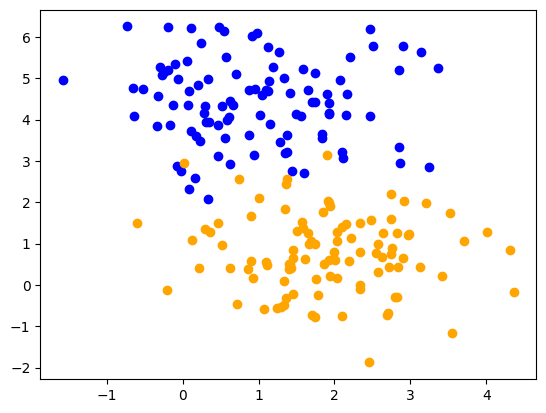

In [8]:
from sklearn.datasets import make_blobs
X_blobs, y_blobs = make_blobs(n_samples=200, centers=2, n_features=2, random_state=0)
import matplotlib.pyplot as plt
plt.scatter(X_blobs[y_blobs==0,0], X_blobs[y_blobs==0,1], color='blue')
plt.scatter(X_blobs[y_blobs==1,0], X_blobs[y_blobs==1,1], color='orange')


<div dir = rtl>
<p>
קביעת מספר איטרציות האימון וקצב הלמידה. באימון הראשון השתמשו בפרמטרים אלה. לאחר מכן אתם יכולים לשנות אותם ולראות את ההשפעה על תהליך האימון
</p>
</div>

In [9]:
epochs_blobs = 2000000
alpha = 0.01

<div dir = rtl>
<p>
זו הרשת שנרצה שתתחילו אתה
</p>
</p>

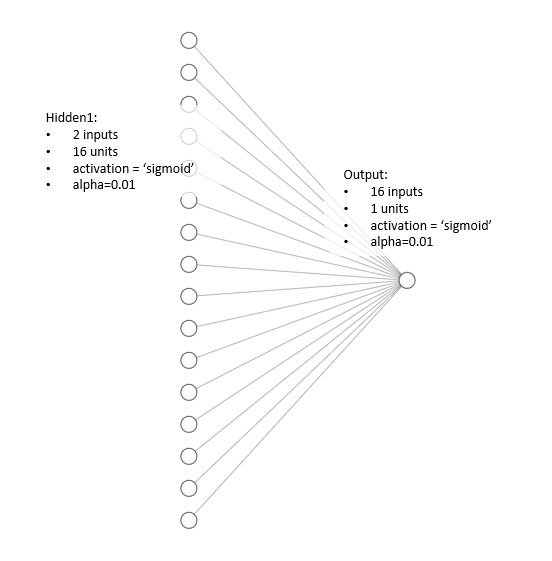

<div dir = rtl>
<h3>
<a href = 'https://docs.google.com/forms/d/e/1FAIpQLSdXa0s2gQn_HT6AJvCvwl0GoOgh_1CmYFlfO2UUFHShtq1iWg/viewform?usp=sf_link'> לפני שאתם בונים את הרשת, ענו על השאלה בטופס הזה</a>
</h3>
<p>
אנא אל תמשיכו לפני שעניתם נכון לפחות פעם אחת. תקנו אם עניתם לא נכון וכמובן, אם עניתם נכון, אין צורך לענות שוב
<br>
בנו את הרשת
</p>
</div>

In [10]:
hidden1 = NeuronLayer_v2(2 ,16 ,alpha , activation = 'sigmoid')
output = NeuronLayer_v2(16 ,1 ,alpha , activation = 'sigmoid')
network_blobs = [hidden1 , output]


<div dir = rtl>
<p>
אמנו את הרשת לפי ההיפר- פרמטרים שהוגדרו
</p>
</div>

In [11]:
history_blobs = fit(network_blobs,X_blobs,y_blobs,epochs_blobs,alpha,cross_entropy,dcross_entropy_dy_hat)


cost: 0.6934163915398505
cost: 0.06596554262749392
cost: 0.06247398665354489
cost: 0.05435984392480012
cost: 0.052650570497263155
cost: 0.05209643166844542
cost: 0.0517128435254552
cost: 0.051399857749220325
cost: 0.051136013294715905
cost: 0.05087769434580869


<div dir = rtl>
<p>
הציגו תרשים של התכנסות ה loss ביחס למספר האיטרציות</p>
</div>

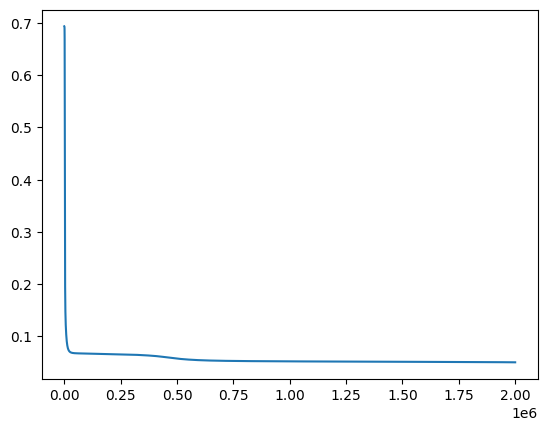

In [12]:
plt.plot(history_blobs)

<div dir = rtl>
<p>
הציגו את תרשים ה- decision boundary על ידי זימון הפעולה בתחילת המחברת עם הפרמטרים המתאימים
</p>
</div>

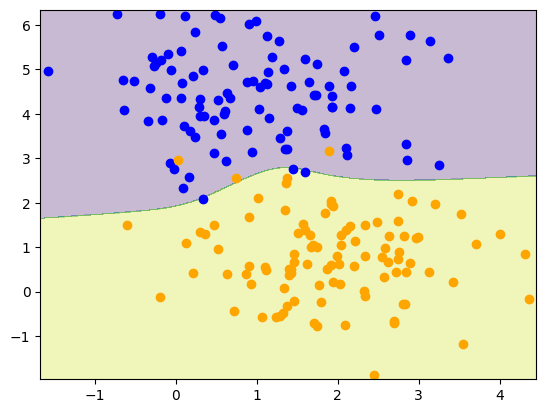

In [13]:
plot_decision_boundaries(X_blobs , y_blobs , network_blobs)

<div dir = rtl>
<p>
חשבו והציגו את מדד ה- accuracy של הרשת ביחס לנתוני האימון
</p>
</div>

In [14]:
pred_blobs = predict(network_blobs , X_blobs , act = 'sigmoid')
accuracy_blobs = np.sum(np.where(pred_blobs.T[0] == y_blobs , 1 , 0)) / y_blobs.shape[0]
print("Accuracy Blobs:", accuracy_blobs)

Accuracy Blobs: 0.97


<div dir = rtl>
<h2>
5. Moon
</h2>
<p>
טעינת הנתונים למשתנים X_moon , y_moon
<br>
scatter plot של נתוני האימון
</p>
</div>

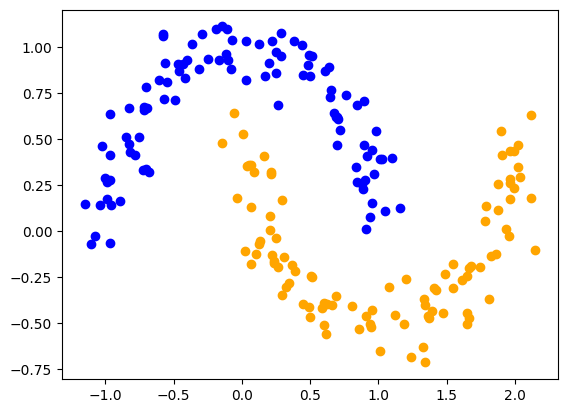

In [15]:
from sklearn.datasets import make_moons
X_moon, y_moon = make_moons(n_samples=200, noise=0.1)
plt.scatter(X_moon[y_moon==0,0], X_moon[y_moon==0,1], color='blue')
plt.scatter(X_moon[y_moon==1,0], X_moon[y_moon==1,1], color='orange')

<div dir = rtl>
<p>
קביעת מספר איטרציות האימון וקצב הלמידה. באימון הראשון השתמשו בפרמטרים אלה. לאחר מכן אתם יכולים לשנות אותם ולראות את ההשפעה על תהליך האימון
</p>
</div>

In [16]:
epochs_blobs = 2000000
alpha = 0.01

<div dir = rtl>
<p>
זו הרשת שנרצה שתתחילו אתה
</p>
</div>

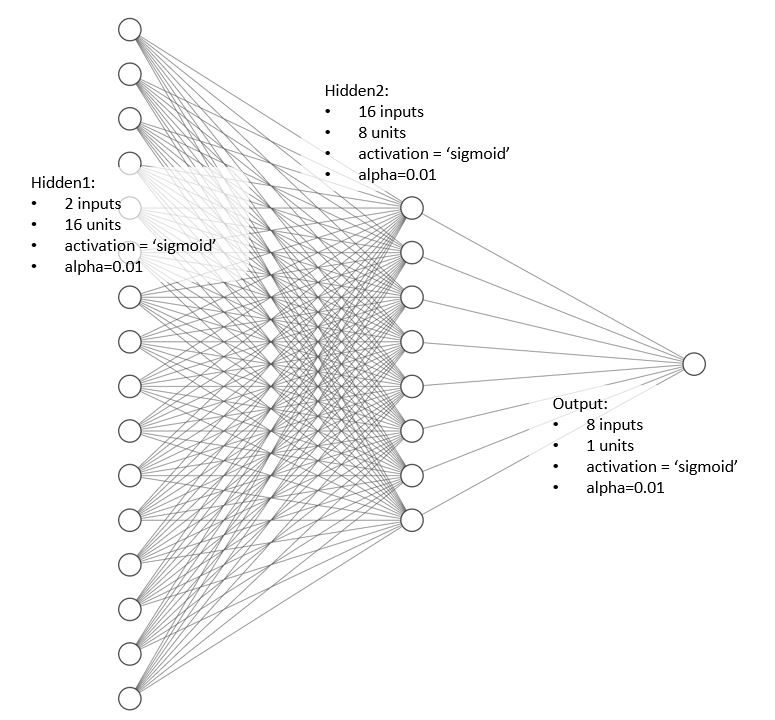

<div dir = rtl>
<h3>
<a href = 'https://docs.google.com/forms/d/e/1FAIpQLScxwqMONpane81z153J2On_JnYWSF3xags26Ff_ecUW9tnMEA/viewform?usp=sf_link'> לפני שאתם ממשיכים, ענו על השאלה בטופס הזה</a>
</h3>
<p>
אנא אל תמשיכו לפני שעניתם נכון לפחות פעם אחת. תקנו אם עניתם לא נכון וכמובן, אם עניתם נכון, אין צורך לענות שוב
<br>
בנו את הרשת
</p>
</div>

In [17]:
hidden1=NeuronLayer_v2(2,16,alpha,'sigmoid')
hidden2=NeuronLayer_v2(16,8,alpha,'sigmoid')
output=NeuronLayer_v2(8,1,alpha,'sigmoid')
network_moon = [hidden1,hidden2,output]

<div dir = rtl>
<p>
אמנו את הרשת לפי ההיפר- פרמטרים שהוגדרו
</p>
</div>

In [18]:
history_moon = fit(network_moon,X_moon,y_moon,epochs_blobs,alpha,cross_entropy,dcross_entropy_dy_hat)

cost: 0.693177331997664
cost: 0.6931468149850659
cost: 0.6929148160257088
cost: 0.24793116610144225
cost: 0.11641598076991709
cost: 0.008993275092075094
cost: 0.0039353465549161895
cost: 0.0023311641278486975
cost: 0.0016281285432111752
cost: 0.0012324550315419714


<div dir = rtl>
<p>
הציגו תרשים של התכנסות ה loss ביחס למספר האיטרציות
</p>
</div>

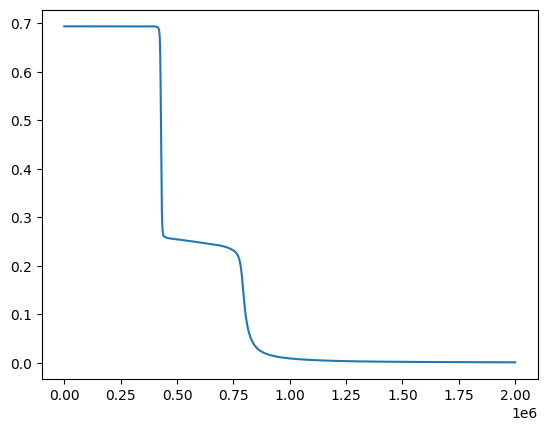

In [19]:
plt.plot(history_moon)

<div dir = rtl>
<p>
הציגו את תרשים ה- decision boundary על ידי זימון הפעולה בתחילת המחברת עם הפרמטרים המתאימים
</p>
</div>

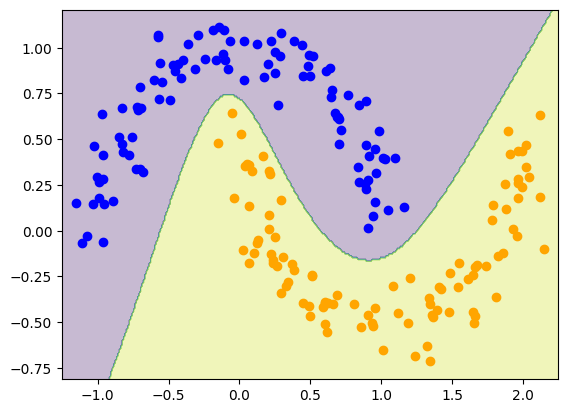

In [20]:
plot_decision_boundaries(X_moon , y_moon , network_moon)

<div dir = rtl>
<p>
חשבו והציגו את מדד ה- accuracy של הרשת ביחס לנתוני האימון
</p>
</div>

In [21]:
pred_moon = predict(network_moon , X_moon , act = 'sigmoid')
accuracy_moon = np.sum(np.where(pred_moon.T[0] == y_moon , 1 , 0)) / y_moon.shape[0]
print("Accuracy Moon:", accuracy_moon)

Accuracy Moon: 1.0


<div dir = rtl>
<h2>
5. Planar
</h2>
<p>
טעינת הנתונים למשתנים X_planar , y_planar
<br>
scatter plot של נתוני האימון
</p>
</div>

In [22]:
def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    Y = Y.T[0]

    return X, Y

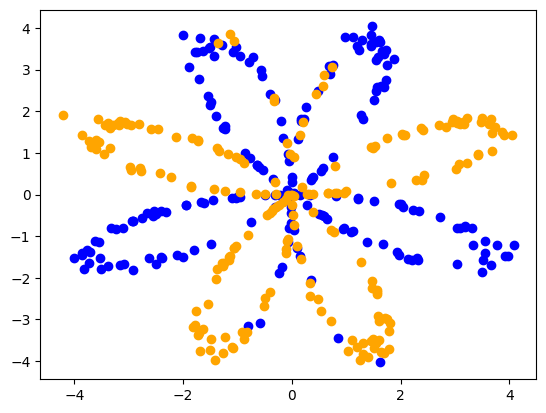

In [23]:
X_planar , y_planar = load_planar_dataset()
plt.scatter(X_planar[y_planar==0,0], X_planar[y_planar==0,1], color='blue')
plt.scatter(X_planar[y_planar==1,0], X_planar[y_planar==1,1], color='orange')

<div dir = rtl>
<p>
קביעת מספר איטרציות האימון וקצב הלמידה. באימון הראשון השתמשו בפרמטרים אלה. לאחר מכן אתם יכולים לשנות אותם ולראות את ההשפעה על תהליך האימון
</p>
</div>

In [24]:
epochs_planar = 400000
alpha = 0.05

<div dir = rtl>
<p>
זו הרשת שנרצה שתתחילו אתה
</p>
</div>

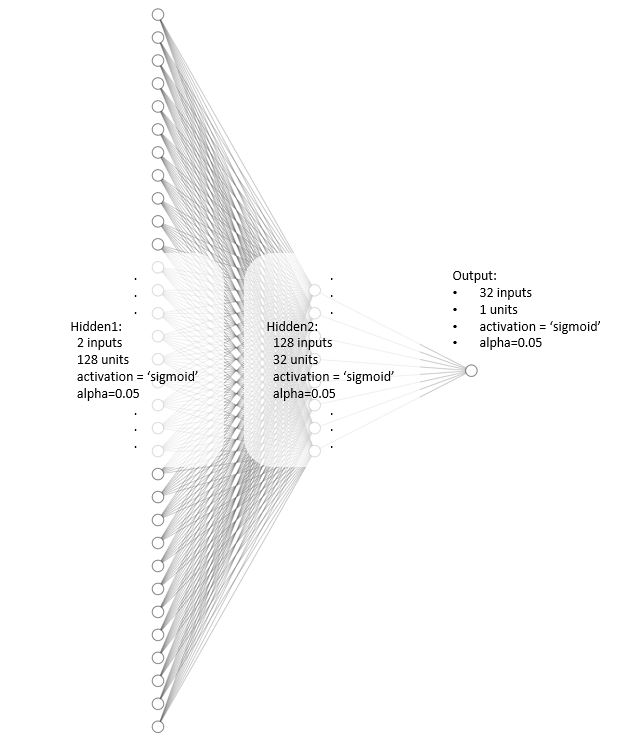

<div dir = rtl>
<h3>
<a href = 'https://docs.google.com/forms/d/e/1FAIpQLSfUR4jelouBOWjDKFL15Sr8_x_bxlxzUnf6h6adaH8IL1NPKw/viewform?usp=sf_link'> לפני שאתם ממשיכים, ענו על השאלה בטופס הזה</a>
</h3>
<p>
אנא אל תמשיכו לפני שעניתם נכון לפחות פעם אחת. תקנו אם עניתם לא נכון וכמובן, אם עניתם נכון, אין צורך לענות שוב
<br>
בנו את הרשת
</p>
</div>

In [25]:
hidden1=NeuronLayer_v2(2,128,alpha,'sigmoid')
hidden2=NeuronLayer_v2(128,32,alpha,'sigmoid')
output=NeuronLayer_v2(32,1,alpha,'sigmoid')
network_planar = [hidden1,hidden2,output]

<div dir = rtl>
<p>
אמנו את הרשת לפי ההיפר- פרמטרים שהוגדרו
</p>
</div>

In [26]:
history_planar = fit(network_planar,X_planar,y_planar,epochs_planar,alpha,cross_entropy,dcross_entropy_dy_hat)

cost: 0.6939718018735138
cost: 0.6930220646154683
cost: 0.617742756927449
cost: 0.28874876356622464
cost: 0.23762320934180173
cost: 0.19522855124439098
cost: 0.18117710490644512
cost: 0.17404079916472512
cost: 0.16804560197777307
cost: 0.16158524089657622


<div dir = rtl>
<p>
הציגו תרשים של התכנסות ה loss ביחס למספר האיטרציות
</p>
</div>

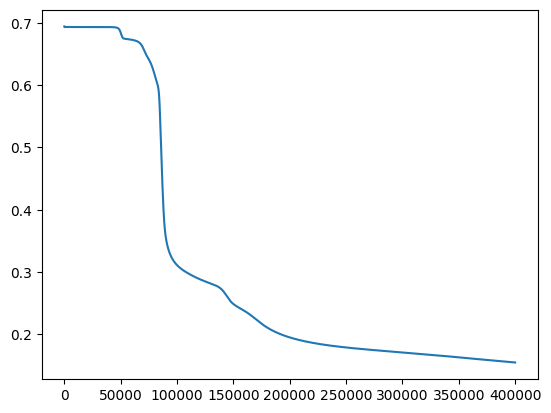

In [27]:
plt.plot(history_planar)

<div dir = rtl>
<p>
הציגו את תרשים ה- decision boundary על ידי זימון הפעולה בתחילת המחברת עם הפרמטרים המתאימים
</p>
</div>

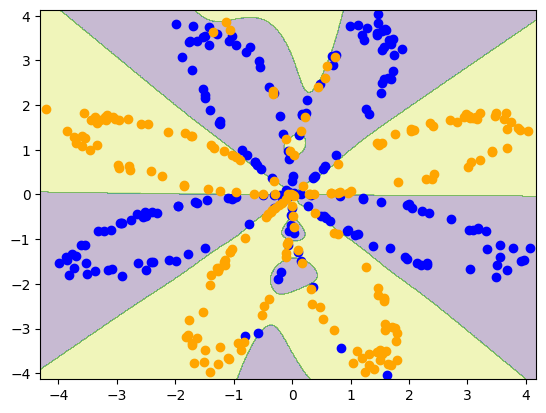

In [28]:
plot_decision_boundaries(X_planar , y_planar , network_planar)

<div dir = rtl>
<p>
חשבו והציגו את מדד ה- accuracy של הרשת ביחס לנתוני האימון
</p>
</div>

In [29]:
pred_planar = predict(network_planar , X_planar , act = 'sigmoid')
accuracy_planar = np.sum(np.where(pred_planar.T[0] == y_planar , 1 , 0)) / y_planar.shape[0]
print("Accuracy Planar:", accuracy_planar)

Accuracy Planar: 0.9175
